In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#랜덤 시드 고정 : 학습을 위한 실험을 할 때 무작위성을 컨트롤하기 위해 사용한다. 
torch.manual_seed(777) #cpu 연산 고정

if device == "cuda:0":
    torch.cuda.manual_seed_all(777) # 멀티 gpu 연산 무작위 고정 

import time
import copy

from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(device)

cuda:0


In [3]:
from tqdm.notebook import tqdm

def training_model(model, data_loader, epochs):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())  # 모든 epoch에서 학습 된 모델 중 best model의 가중치를 저장하는 변수
    best_acc = 0

    for epoch in range(epochs):
        avg_cost = 0

        for phase in ['train', 'val']:  # train mode와 validation mode 순으로 진행
            if phase == 'train':
                model.train()  # model을 training mode로
            else:
                model.eval()   # model을 validation mode로(드롭아웃, 배치정규화 등을 사용하지 않음) = testmode

            for X, Y in tqdm(data_loader[phase]):
                X, Y = X.to(device), Y.to(device)

                optimizer.zero_grad()   # 지난 iteration에서 계산했던 기울기 초기화

                with torch.set_grad_enabled(phase == 'train'):  # training mode에서는 gradient를 기억하여 가중치를 수정해야 함
                                                                # validation mode에서는 가중치를 수정하지 않으므로 필요 없음 : with torch.no_grad():
                    hypothesis = model(X)   # 순전파 과정으로 예측값 도출(train 과정)
                    cost = criterion(hypothesis, Y)   # 예측값과 실제값을 비교한 loss

                    if phase == 'train':
                        cost.backward()   # 역전파, 기울기 계산
                        optimizer.step()   # optimizer로 가중치 갱신
                        avg_cost += cost / total_batch[phase]

                    else: # validation에서는 역전파로 가중치를 학습할 필요 없음
                        prediction = model(X)   # 학습한 모델로 test 데이터의 예측값 도출(각 숫자에 해당할 확률)
                        prediction = prediction.to(device) #gpu 연산
                        correct_prediction = torch.argmax(prediction, 1) == Y   # 모든 확률 중에서 가장 큰 확률을 가진 숫자를 예측값으로 지정하고 이를 실제값과 비교
                        #다시 곱씹을 필요성 있음
                        global accuracy #글로벌 변수 지정 
                        accuracy = correct_prediction.float().mean().item()   # 정확도 계산

            if phase == 'train':
                print('[Epoch: {:>4}] train cost = {:.4f}'.format(epoch + 1, avg_cost)) # training 과정에서 각 epoch 마다의 cost 출력
            else:
                print('val Accuracy = {:.4f}'.format(accuracy))  # validation 과정에서 각 epoch에서 학습된 모델의 성능 출력
                print('='*100)

            if phase == 'val' and accuracy > best_acc:  # 이번 epoch에서 만들어진 모델이 이전에 만들어진 모델보다 더 성능이 좋을 경우, best model을 수정
                best_acc = accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

    training_time = time.time() - since   # 학습 경과 시간
    
    print('total training time for {} epochs: {:.0f}m {:.0f}s'.format(epochs, training_time//60, training_time%60))
    print('Best val Accuracy: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts) #  state_dict : 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다.
    return model  # best model 반환


# CIFAR-10 Dataset

CIFAR-10 데이터셋은 10개의 클래스로 분류되는 사물 이미지로 구성된 Computer Vision의 대표적이 데이터셋이다. 한 이미지는 32*32 크기로 이루어져 있으며, 컬러 이미지이므로 3개의 채널(RGB)로 구성되어 있다. 각 클래스 당 5000개의 training 데이터와 1000개의 test 데이터를 갖고 있다. (총 training set: 50000개, 총 test set: 10000개)

torchvision 을 사용하여 CIFAR-10 데이터셋을 불러오고, 정규화(nomarlizing)할 수 있다. 자세한 내용은 https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html 참고

In [4]:
# Data Augmentation
transform = transforms.Compose([
                                transforms.Resize(256), 
                                transforms.RandomCrop(227), #227 * 227
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #3채널(R,G,B) 데이터의 평균과 분산을 0.5로 설정

])

In [5]:
batch_size = 64 #GPU의 메모리가 2의 거듭제곱이기 때문에 가장 효율적인 batch_size는 2의 거듭제곱으로 맞추는 것이다. Batch size가 작을수록, 시간은 오래걸리지만 효과는 좋다(일반적인 상황) 



cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)  #batch_size는 원하는 크기로 변경 가능. 
                                                                                              #단, 2의 제곱수로 하고 test_loader의 batch_size도 동일한 수로 변경할 것.

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.data/cifar-10-python.tar.gz to /root/.data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


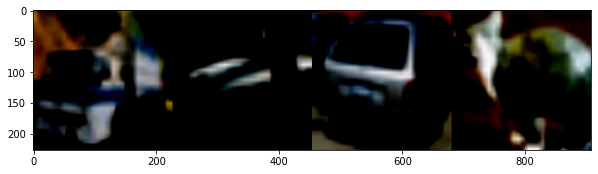

In [6]:
dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images[:4], padding=0)
npimg = img.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

# AlexNet

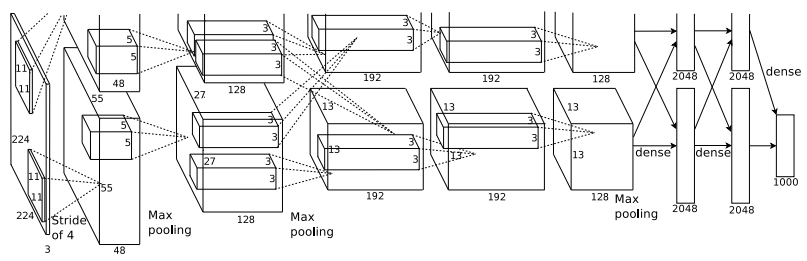

CNN 구조에서 큰 발전을 이끈 신경망이다. 

2개의 GPU에서 신경망 학습, LRN 사용, overlapping pooling 등의 기법을 통해 성능을 크게 향상시켰다.

In [7]:
class AlexNet(nn.Module):
    def __init__(self, input_size = 227, num_classes=10):  # data augmentation 과정에서 이미지 크기를 227로 crop했으므로, input_size = 227
                                                           # CIFAR-10 데이터는 총 10개의 종류로 분류되므로, num_classes = 10
        super(AlexNet, self).__init__()

        # CNN Layer
        self.CNNLayer = nn.Sequential(
            # 1st Conv layer
# '''
#             Q1. 바로 하단의 layer후에 size가 227->55가 되도록 kernel_size 설정
# '''
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=4, padding = 0, stride=4),  
# '''
#             Q2. 아래의 활성화 함수(####) 채워 넣기 (모든 layer에 대해)
#             Q3. pooling 방식(함수) 채워 넣기 (모든 layer에 대해)
# '''            
            nn.ReLU(inplace=True),  

            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # LRN
            nn.MaxPool2d(kernel_size=3, stride=2),  # overlap pooling, 55->27

            # 2nd Conv layer
            nn.Conv2d(96, 256, 5, padding = 2, stride = 1),  # 27->27
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 27->13

            # 3rd Conv layer
            nn.Conv2d(256, 384, 3, padding = 1, stride = 1),  # 13->13
            nn.ReLU(inplace=True),

            # 4th Conv layer
            nn.Conv2d(384, 384, 3, padding = 1, stride = 1),  # 13->13
            nn.ReLU(inplace=True),

            # 5th Conv layer
            nn.Conv2d(384, 256, 3, padding=1),  # 13->13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 13->6
        )
        
        # Fully-connected Layer
        self.FCLayer = nn.Sequential(
            # 1st FC layer
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            # 2nd FC layer
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            # 3nd FC layer & classifier
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
        self.init_bias()  # bias 초기화
        
    def init_bias(self):
        for layer in self.CNNLayer:
            if isinstance(layer, nn.Conv2d):
                # weight와 bias 초기화
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # 논문에 2,4,5 conv2d layer의 bias는 1로 초기화한다고 나와있습니다.  
        nn.init.constant_(self.CNNLayer[4].bias, 1)
        nn.init.constant_(self.CNNLayer[10].bias, 1)
        nn.init.constant_(self.CNNLayer[12].bias, 1)
        
    def forward(self, x):
        output = self.CNNLayer(x)
        output = output.view(-1, 256 * 6 * 6)
        output = self.FCLayer(output)
        return output

In [8]:
alexnet = AlexNet(227, 10)
alexnet.to(device)

AlexNet(
  (CNNLayer): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCLayer): Sequential(
    (0): Linear(in_features=9216, out_features=4096, b

In [9]:
learning_rate = 0.01 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [10]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(alexnet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의
#weight decay: 특정 가중치값이 커져 Overfitting이 일어나는 것을 막기 위해 특정값을 손실함수에 더해주는 것 >> 가중치 감쇠

In [12]:
alexnet = training_model(model = alexnet, data_loader = data_loaders, epochs = training_epochs)

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    1] train cost = 2.3031


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = 0.1250


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    2] train cost = 2.3032


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = 0.1875


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch:    3] train cost = 2.3031


  0%|          | 0/157 [00:00<?, ?it/s]

val Accuracy = 0.3125
total training time for 3 epochs: 6m 38s
Best val Accuracy: 0.3125


위처럼 torch 환경에서 직접 신경망을 구현할 수도 있지만 torchvision의 models 패키지에 저장된 모델을 불러와 사용할 수도 있다. torchvision에 저장된 딥러닝 모델은 단순히 구조만 있는 버전과 ImageNet 데이터로 pretrained된 버전 두가지가 있다. 자세한 내용은 https://pytorch.org/vision/0.8/models.html 참고

In [13]:
import torchvision.models as models

alexnet = models.alexnet(pretrained=True) #pretrained 사용, 직접구성 X
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 10)  # pretrained된 모델의 마지막 레이어 노드 개수는
                                                 # 우리가 사용하는 데이터의 num_classes와 다르므로 바꿔줘야 한다.
alexnet.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(alexnet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

# alexnet = training_model(model = alexnet, data_loader = data_loaders, epochs = training_epochs)

# VGGNet

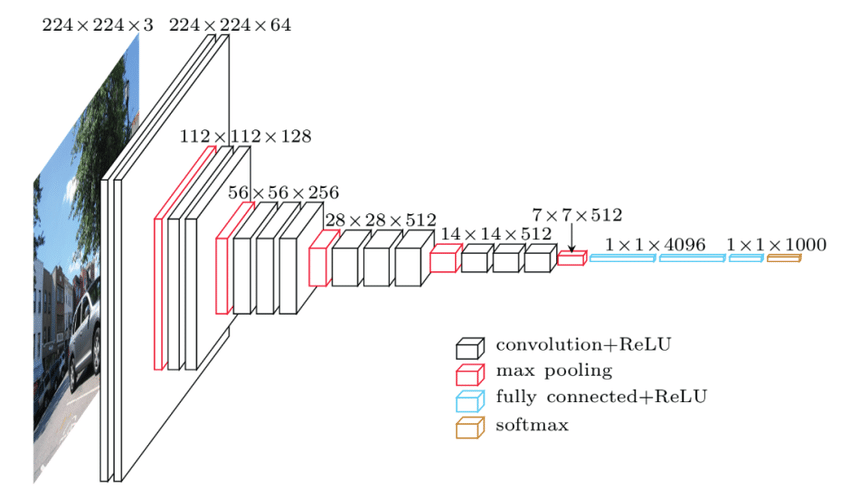

이전 CNN 구조보다 훨씬 더 많은 레이어를 사용하여 깊게 만든 신경망이다. 

깊이를 증가시켜 정확도를 높이면서도 filter 사이즈를 조정하여 파라미터 수가 크게 늘어나지 않도록 했다.

block code

In [15]:
def conv_2_block(in_features, out_features): #2 conv layers
        net = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        return net

In [16]:
def conv_3_block(in_features, out_features): #3 conv layers
        net = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size = 3, padding = 1), #channel size in,out 동일
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        return net

'''
Q4. 아래의 셀에 직접 conv block 갯수를 함수의 파라미터로 설정해서 넣을 수 있는 코드를 작성 (책/수업의 코드 참고)
'''

In [17]:
def vgg_block(num_convs,in_channels,out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels 
    layers.append(nn.MaxPool2d(2,2))
    return nn.Sequential(*layers) #list unpacking 반드시 필요하다!
    

In [18]:
class VGGNet(nn.Module):
    def __init__(self, input_size = 227, num_classes=10):
        super(VGGNet, self).__init__()



        self.CNNLayer = nn.Sequential(
            conv_2_block(3, 64), # 3->64
            conv_2_block(64, 128), # 64->128
            conv_3_block(128, 256), # 128->256
            conv_3_block(256, 512), # 256->512
            conv_3_block(512, 512), # 512->512        
        )

        #self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.FCLayer = nn.Sequential(
            nn.Linear(512*4*4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        output = self.CNNLayer(x)
        #output = self.avgpool(output)
        output = output.view(-1, output.size(0))
        output = self.FCLayer(output)
        return output

In [19]:
vggnet = VGGNet(227, 10)
vggnet.to(device)

VGGNet(
  (CNNLayer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, 

In [20]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True) #pretrained
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 10) #class 개수 10개로 맞춰주기 = CIFAR 10 

vgg16.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [22]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(vgg16.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

In [23]:
# #모델 학습
# training_model(model = vgg16, data_loader = data_loaders, epochs = training_epochs)

# GoogleNet

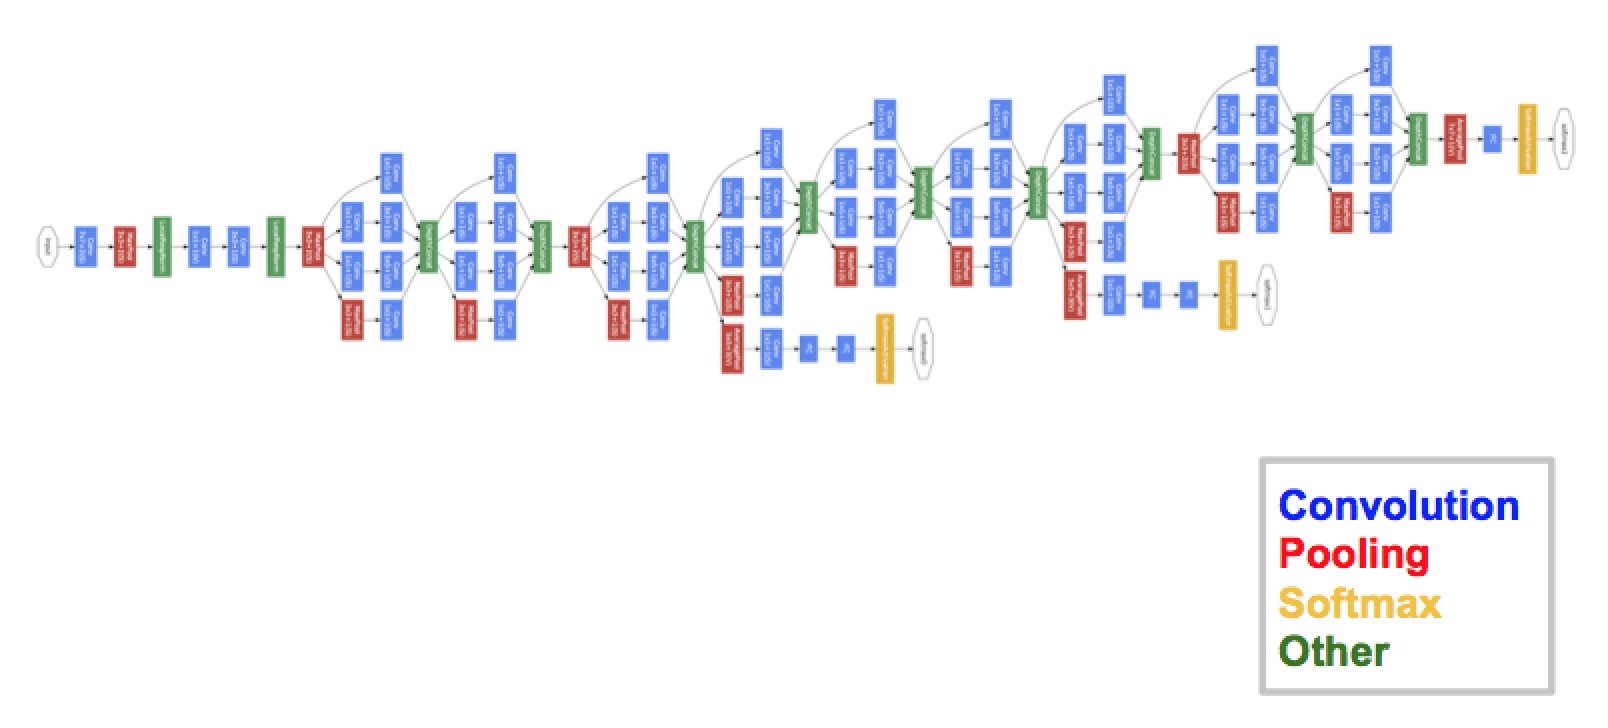

딥러닝 신경망이 깊어지면 그 구조가 sparse한 특징을 가지기 때문에 계산의 비효율성이 커진다. GoogLeNet은 이를 해결하기 위해 inception module이라는 것을 사용하여 신경망 내에 또다른 신경망을 넣은 것이다.

In [24]:
def conv_1(in_features,out_features):
    net = nn.Sequential(
        nn.Conv2d(in_features, out_features, 1, 1),
        nn.ReLU(),
    )
    return net

In [25]:
def conv_1_3(in_features, mid_features, out_features):
    net = nn.Sequential(
        nn.Conv2d(in_features, mid_features, 1, 1),
        nn.ReLU(),
        nn.Conv2d(mid_features, out_features, 3, 1, 1), #kernel, stride, padding순 암기하라
        nn.ReLU()
    )
    return net

In [26]:
def conv_1_5(in_features, mid_features, out_features):
    net = nn.Sequential(
        nn.Conv2d(in_features, mid_features, 1, 1),
        nn.ReLU(),
        nn.Conv2d(mid_features, out_features, 5, 1, 2),
        nn.ReLU()
    )
    return net

In [27]:
def max_3_1(in_features, out_features):
    net = nn.Sequential(
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
        nn.Conv2d(in_features, out_features, 1, 1),
        nn.ReLU(),
    )
    return net

'''
Q5. 아래의 빈칸(####)을 위에 정리된 path함수들로 채워넣기
'''

In [28]:
class inception_module(nn.Module):
    def __init__(self, in_features, out_features_1, mid_features_3, out_features_3,
                 mid_features_5, out_features_5, pool_features):
        super(inception_module, self).__init__()

        # 1x1 -> 1x1
        self.conv_1 = conv_1(in_features, out_features_1)
        
        # 1x1 -> 3x3
        self.conv_1_3= conv_1_3(in_features, mid_features_3, out_features_3)
        
        # 1x1 -> 5x5
        self.conv_1_5 = conv_1_5(in_features, mid_features_5, out_features_5)
        
        # 3x3 -> 1x1
        self.max_3_1 = max_3_1(in_features, pool_features)

    def forward(self,x):
        output_1 = self.conv_1(x)
        output_2 = self.conv_1_3(x)
        output_3 = self.conv_1_5(x)
        output_4 = self.max_3_1(x)

        output = torch.cat([output_1, output_2, output_3, output_4], 1) # 모든  output 이어붙이기 , 1은 1차원을 의미(dim)

        return output

In [29]:
class GoogLeNet(nn.Module):
    def __init__(self, base_features, num_classes = 10):
        super(GoogLeNet, self).__init__()
        self.num_classes = num_classes

        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.MaxPool2d(3, 2, 1),
            nn.Conv2d(64, 192, 3, 1, 1),
            nn.MaxPool2d(3, 2, 1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(192, 64, 96, 128, 16, 32, 32),
            inception_module(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, 1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480, 192, 96, 208, 16, 48, 64),
            inception_module(512, 160, 112, 224, 24, 64, 64),
            inception_module(512, 128, 128, 256, 24, 64, 64),
            inception_module(512, 112, 144, 288, 32, 64, 64),
            inception_module(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2, 1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832, 256, 160, 320, 32, 128, 128),
            inception_module(832, 384, 192, 384, 48, 128, 128), 
            nn.AvgPool2d(7, 1),
        )
        self.layer_5 = nn.Dropout2d(0.4)

        self.FCLayer = nn.Linear(1024, self.num_classes)
                
        
    def forward(self, x):
        output = self.layer_1(x)
        output = self.layer_2(output)
        output = self.layer_3(output)
        output = self.layer_4(output)
        output = self.layer_5(output)
        output = output.view(batch_size, -1)
        output = self.FCLayer(output)
        return output

In [30]:
googlenet = GoogLeNet(64, 10)
googlenet.to(device)

GoogLeNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): inception_module(
      (conv_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (conv_1_3): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (conv_1_5): Sequential(
        (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): ReLU()
      )
      (max_3_1): Sequential

In [31]:
import torchvision.models as models

googlenet = models.googlenet(pretrained=True)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 10) #CIFAR class개수로 맞춰주기 

googlenet.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [32]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [33]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(googlenet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

In [34]:
# #모델 학습
# training_model(model = googlenet, data_loader = data_loaders, epochs = training_epochs)

# ResNet

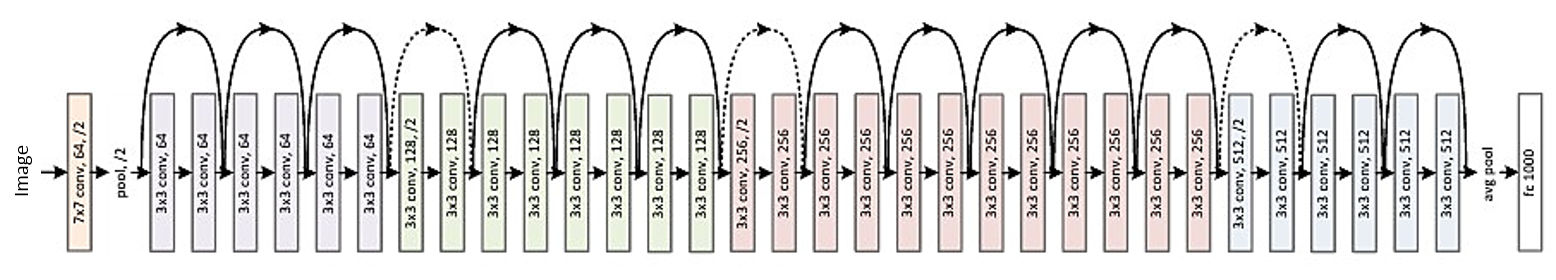

깊은 딥러닝 신경망에서 발생하는 기울기 소실/폭발 문제를 해결하기 위해 residual block을 사용하는 신경망이다. 

In [35]:
def conv_block_1(in_features, out_features, stride=1):
    net = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=1, stride = stride), 
        nn.BatchNorm2d(out_features), 
        nn.ReLU(),
    )
    return net

In [36]:
def conv_block_3(in_features, out_features, stride=1):
    net = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size = 3, stride = stride, padding = 1), 
        nn.BatchNorm2d(out_features), 
        nn.ReLU(),
    )
    return net

In [37]:
class BottleNeck(nn.Module):
    def __init__(self, in_features, mid_features, out_features, down=False):
        super(BottleNeck, self).__init__()
        self.down=down
        
        # feature map 크기가 감소하는 경우
        if self.down:
            self.layer = nn.Sequential(
              conv_block_1(in_features, mid_features, stride=2), 
              conv_block_3(mid_features, mid_features, stride=1), 
              conv_block_1(mid_features, out_features, stride=1), 
            )
            self.downsample = nn.Conv2d(in_features, out_features, kernel_size=1, stride=2)
            
        # feature map의 크기가 유지되는 경우
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_features, mid_features, stride=1), 
                conv_block_3(mid_features, mid_features, stride=1), 
                conv_block_1(mid_features, out_features, stride=1), 
            )

        self.dim_equalizer = nn.Conv2d(in_features, out_features, kernel_size=1)
                  
    def forward(self, x):
        if self.down:
            downsample = self.downsample(x)
            output = self.layer(x)
            output = output + downsample
        else:
            output = self.layer(x)
            if x.size() is not output.size():
                x = self.dim_equalizer(x)
            output = output + x
        return output

In [38]:
class ResNet(nn.Module): #image input: 227
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
# '''
# Q6. 빈칸 채워넣기
# '''
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,64,7,2,3),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1), #kernel, stride, padding
        )
        self.layer_2 = nn.Sequential(
            BottleNeck(64,64,256),
            BottleNeck(256,64,256),
            BottleNeck(256,64,256,down=True),
        )   
        self.layer_3 = nn.Sequential(
            BottleNeck(256,128,512),
            BottleNeck(512,128,512),
            BottleNeck(512,128,512),
            BottleNeck(512,128,512,down=True),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck(512,256,1024),
            BottleNeck(1024,256,1024),
            BottleNeck(1024,256,1024),            
            BottleNeck(1024,256,1024),
            BottleNeck(1024,256,1024),
            BottleNeck(1024,256,1024,down=True),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck(1024,512,2048),
            BottleNeck(2048,512,2048),
            BottleNeck(2048,512,2048),
        )
        self.avgpool = nn.AvgPool2d(1,1) 
        self.fc_layer = nn.Linear(2048,num_classes)
        
    def forward(self, x):
        output = self.layer_1(x)
        output = self.layer_2(output)
        output = self.layer_3(output)
        output = self.layer_4(output)
        output = self.layer_5(output)
        output = self.avgpool(output)
        output = output.view(batch_size,-1)
        output = self.fc_layer(output)
        
        return output

In [39]:
resnet = ResNet(10)
resnet.to(device)

ResNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): BottleNeck(
      (layer): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (dim_equalizer): Conv2d(64, 256, 

In [40]:
import torchvision.models as models

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 3 #반복학습의 횟수

In [42]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)   #optimizer 정의

In [43]:
# #모델 학습
# training_model(model = resnet, data_loader = data_loaders, epochs = training_epochs)

# 지난 주 과제 적용

1. 빈칸 채워넣기! (Q1.~)
2. 위의 총 네가지의 cnn모델 중 한가지(혹은 이상)을 선택하여 지난주에 사용한 dataset에 직접 적용시켜보기! 


In [44]:
#텐서로 변환
train_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [45]:
#텐서로 변환
dtd_train = datasets.DTD(
    root="../data", split='train', transform = train_transform, download=True)
dtd_test = datasets.DTD(
    root="../data", split='test', transform = test_transform, download=True)

  0%|          | 0/625239812 [00:00<?, ?it/s]

Extracting ../data/dtd/dtd-r1.0.1.tar.gz to ../data/dtd


In [46]:
#이미지 정규화를 위해 함수를 만든다.
def get_mean_std(dataset):
    #train의 각 image의 RGB채널별 픽셀값들의 평균, 표준편차(1880개의 Image)
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])
    
    mean = [meanR,meanG,meanB]
    std = [stdR,stdG,stdB]
    
    return mean,std

In [47]:
#저번 과제 때는 64*64 size로 이미지 사이즈를 조정했었는데
#이번에는 pretrained된 복잡한 모델을 쓸것이므로 224*224로 조절

mean = get_mean_std(dtd_train)[0]
std = get_mean_std(dtd_train)[1]


dtd_train.transform = transforms.Compose([
    transforms.Resize((256,256)), #이미지 크기 조정(conv층 통과하기 위함)
    transforms.RandomResizedCrop(224),  #데이터 확장 용도. 이미지 랜덤 비율로 자름.
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
    ])

dtd_test.transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std) #testset은 평균, 표준편차를 구하는 것이 아니라 train 데이터에서 추출한 것을 적용해야한다.
    ]) #mean, std

In [48]:
batch_size = 16 #2의 거듭제곱으로 조정 (기존 12>>16 : 2의 거듭제곱으로 맞춰주기 위함)

train_loader = torch.utils.data.DataLoader(dtd_train, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dtd_test, batch_size=batch_size,
                                          shuffle=True)

In [49]:
len(dtd_train),len(dtd_test) #train: 1880, test: 1880

(1880, 1880)

In [50]:
print(dtd_train.classes) #47 classes
classes = dtd_train.classes

['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike', 'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 'zigzagged']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


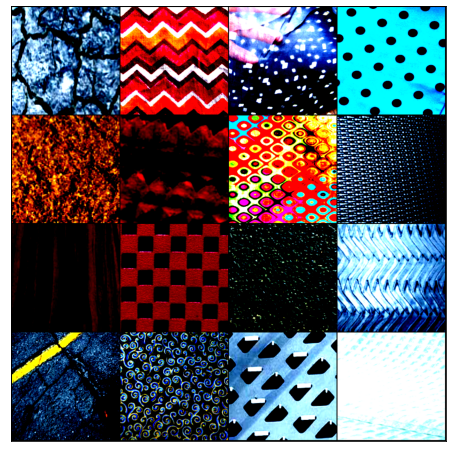

In [51]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (10,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images,nrow=4).permute(1,2,0))
        break
        
show_batch(train_loader)

In [52]:
for X,y in train_loader:  #X: image, Y:label index
    print(X.shape,X.dtype,y.shape,y.dtype)
    break

torch.Size([16, 3, 224, 224]) torch.float32 torch.Size([16]) torch.int64


# Model 1 : ResNet

In [53]:
import torchvision.models as models

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 47) #num_classes

resnet.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
data_loader = {'train':train_loader,'val':test_loader}
total_batch = {'train':len(train_loader),'val':len(test_loader)}
print(total_batch) #배치 사이즈에 따라 1epoch당 batch 개수가 나온다 = 전체 train data 개수 / batchsize
                   #전체 train data 개수가 아니다!!!

{'train': 118, 'val': 118}


In [55]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 5 #반복학습의 횟수

In [56]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay = 0.0005)
#Optimizer로는 Adam을 사용해본다.(저번 과제에 있어서 최고의 optimizer)

In [57]:
from tqdm.notebook import tqdm

def training_model(model, data_loader, epochs):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())  # 모든 epoch에서 학습 된 모델 중 best model의 가중치를 저장하는 변수
    best_acc = 0

    for epoch in range(epochs):
        avg_cost = 0

        for phase in ['train', 'val']:  # train mode와 validation mode 순으로 진행
            if phase == 'train':
                model.train()  # model을 training mode로
            else:
                model.eval()   # model을 validation mode로(드롭아웃, 배치정규화 등을 사용하지 않음) = testmode

            for X, Y in tqdm(data_loader[phase]):
                X, Y = X.to(device), Y.to(device)

                optimizer.zero_grad()   # 지난 iteration에서 계산했던 기울기 초기화

                with torch.set_grad_enabled(phase == 'train'):  # training mode에서는 gradient를 기억하여 가중치를 수정해야 함
                                                                # validation mode에서는 가중치를 수정하지 않으므로 필요 없음 : with torch.no_grad():
                    hypothesis = model(X)   # 순전파 과정으로 예측값 도출(train 과정)
                    cost = criterion(hypothesis, Y)   # 예측값과 실제값을 비교한 loss

                    if phase == 'train':
                        cost.backward()   # 역전파, 기울기 계산
                        optimizer.step()   # optimizer로 가중치 갱신
                        avg_cost += cost / total_batch[phase] #평균 loss = 전체 batch 개수(118)로 나누어준다.(1 epoch당 사이즈 16 batch가 118번 돌아감)

                    else: # validation에서는 역전파로 가중치를 학습할 필요 없음
                        prediction = model(X)   # 학습한 모델로 test 데이터의 예측값 도출(각 숫자에 해당할 확률)
                        prediction = prediction.to(device) #gpu 연산
                        correct_prediction = torch.argmax(prediction, 1) == Y   # 모든 확률 중에서 가장 큰 확률을 가진 숫자를 예측값으로 지정하고 이를 실제값과 비교
                        #다시 곱씹을 필요성 있음
                        global accuracy #글로벌 변수 지정 
                        accuracy = correct_prediction.float().mean().item()   # 정확도 계산

            if phase == 'train':
                print('[Epoch: {:>4}] train cost = {:.4f}'.format(epoch + 1, avg_cost)) # training 과정에서 각 epoch 마다의 cost 출력
            else:
                print('val Accuracy = {:.4f}'.format(accuracy))  # validation 과정에서 각 epoch에서 학습된 모델의 성능 출력
                print('='*100)

            if phase == 'val' and accuracy > best_acc:  # 이번 epoch에서 만들어진 모델이 이전에 만들어진 모델보다 더 성능이 좋을 경우, best model을 수정
                best_acc = accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

    training_time = time.time() - since   # 학습 경과 시간
    
    print('total training time for {} epochs: {:.0f}m {:.0f}s'.format(epochs, training_time//60, training_time%60))
    print('Best val Accuracy: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts) #  state_dict : 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다.
    return model  # best model 반환


In [58]:
#모델 학습
training_model(model = resnet, data_loader = data_loader, epochs = training_epochs)

  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    1] train cost = 2.7013


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.6250


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    2] train cost = 1.6624


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.2500


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    3] train cost = 1.3164


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.2500


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    4] train cost = 1.1365


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.3750


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    5] train cost = 0.9630


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.3750
total training time for 5 epochs: 5m 1s
Best val Accuracy: 0.6250


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Model 2 : GoogleNet

In [59]:
import torchvision.models as models

googlenet = models.googlenet(pretrained=True)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 47) #num_class

googlenet.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [60]:
learning_rate = 0.0001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 5 #반복학습의 횟수

In [61]:
criterion = torch.nn.CrossEntropyLoss().to(device)   # loss function 정의
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay = 0.0005)
#Optimizer로는 Adam을 사용해본다.(저번 과제에 있어서 최고의 optimizer)

In [62]:
#모델 학습
training_model(model = googlenet, data_loader = data_loader, epochs = training_epochs)

  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    1] train cost = 3.9101


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.0000


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    2] train cost = 3.8915


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.0000


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    3] train cost = 3.8964


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.1250


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    4] train cost = 3.8934


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.0000


  0%|          | 0/118 [00:00<?, ?it/s]

[Epoch:    5] train cost = 3.9102


  0%|          | 0/118 [00:00<?, ?it/s]

val Accuracy = 0.0000
total training time for 5 epochs: 3m 37s
Best val Accuracy: 0.1250


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

ResNet은은 62.5%, googlenet은 12.5%의 성능을 보였다. <br>
ResNet은 저번주 직접 만든 CNN에 비해 3배의 성능향상을 보여줬지만 <br>
googlenet은 학습이 원활하게 이뤄지지 않는 모습이다 <br>
그 이유에 대해선 좀 더 탐구해봐야할듯 하다.